<a href="https://colab.research.google.com/github/BenJoyenConseil/transfer_digits/blob/main/MNIST_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikit-learn==1.0.2 pandas matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Classic RF on MNIST

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Load data

In [5]:
df = pd.read_csv('sample_data/mnist_train_small.csv')

In [6]:
df.shape

(19999, 785)

In [7]:
df_x=df.iloc[:,1:]
df_y=df.iloc[:,0]

## exploration

In [8]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)

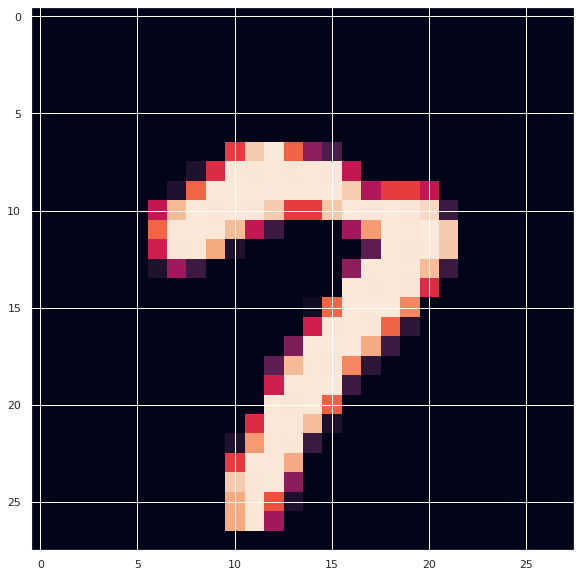

In [9]:
plt.figure(figsize=(12,10))
print_image(10, df_x)

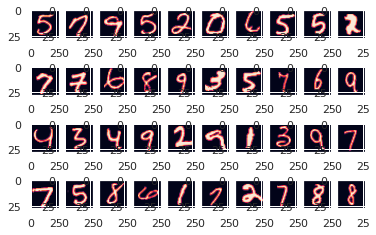

In [10]:
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

1    2243
7    2126
6    2038
9    2023
3    2021
2    1989
0    1962
4    1924
8    1912
5    1761
Name: 6, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


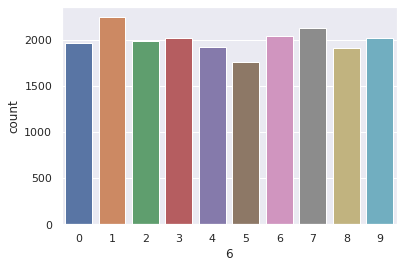

In [11]:
print(df_y.value_counts())
sns.countplot(df_y)

## fit / predict

In [12]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, shuffle=True, random_state=123, train_size=1000)
print(train_x.shape)
print(test_x.shape)

(1000, 784)
(18999, 784)


In [13]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

RandomForestClassifier()

## Rapports

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1875
           1       0.88      0.98      0.93      2123
           2       0.90      0.88      0.89      1884
           3       0.90      0.86      0.88      1922
           4       0.88      0.83      0.86      1838
           5       0.91      0.79      0.85      1681
           6       0.94      0.92      0.93      1941
           7       0.95      0.90      0.92      2017
           8       0.86      0.87      0.86      1801
           9       0.78      0.88      0.83      1917

    accuracy                           0.89     18999
   macro avg       0.89      0.89      0.89     18999
weighted avg       0.89      0.89      0.89     18999



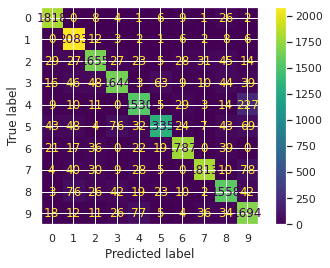

In [14]:
ConfusionMatrixDisplay.from_predictions(test_y, rf.predict(test_x))
print(classification_report(test_y, rf.predict(test_x)))

# Skewed Learning

In [15]:
y_column_name = "6"

In [16]:
df_sorted = df.sort_values(by=y_column_name)

In [17]:
nb_sample=8000
df_x_skewed, df_y_skewed = df_sorted.iloc[:nb_sample,1:], df_sorted.iloc[:nb_sample,0]

In [18]:
rf.fit(df_x_skewed, df_y_skewed)

RandomForestClassifier()

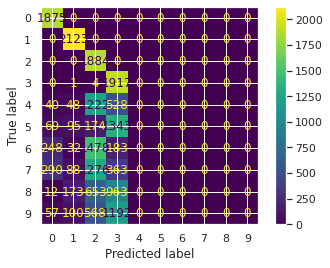

In [19]:
ConfusionMatrixDisplay.from_predictions(test_y, rf.predict(test_x))

In [20]:
print(classification_report(test_y, rf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1875
           1       0.80      1.00      0.89      2123
           2       0.26      1.00      0.41      1884
           3       0.30      1.00      0.46      1922
           4       0.00      0.00      0.00      1838
           5       0.00      0.00      0.00      1681
           6       0.00      0.00      0.00      1941
           7       0.00      0.00      0.00      2017
           8       0.00      0.00      0.00      1801
           9       0.00      0.00      0.00      1917

    accuracy                           0.41     18999
   macro avg       0.21      0.40      0.26     18999
weighted avg       0.22      0.41      0.27     18999



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Approche Clustering

In [131]:
n_clusters = df_y.unique().size
factor_cluster = 2

In [132]:
from sklearn.cluster import MiniBatchKMeans

In [133]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters*factor_cluster, random_state=123, init='k-means++')

In [134]:
kmeans.fit(df_x)

MiniBatchKMeans(n_clusters=20, random_state=123)

In [135]:
print(df_x.shape)
print(kmeans.labels_.shape)

(19999, 784)
(19999,)


In [136]:
def infer_cluster_labels(n_clusters, kmeans_labels, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    cluster_labels = {}

    # Loop through the clusters
    for i in range(n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans_labels == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the cluster_labels dictionary
        if np.argmax(counts) in cluster_labels:
            # append the new number to the existing array at this slot
            cluster_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            cluster_labels[np.argmax(counts)] = [i]
        
    return cluster_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [137]:
cluster_labels = infer_cluster_labels(kmeans.n_clusters, kmeans.labels_, df_y.to_numpy())
X_clusters = kmeans.predict(df_x)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(df_y.to_numpy()[:20])

[3 7 4 3 2 0 6 3 3 2 7 7 6 9 9 0 8 9 1 7]
[5 7 9 5 2 0 6 5 5 2 7 7 6 8 9 3 5 7 6 9]


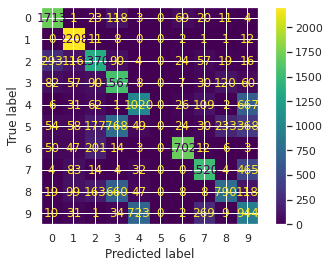

In [138]:
ConfusionMatrixDisplay.from_predictions(df_y, predicted_labels)

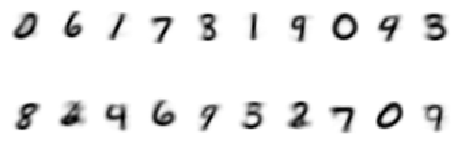

In [139]:
fig, ax = plt.subplots(factor_cluster, n_clusters, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(n_clusters*factor_cluster, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [140]:
print(classification_report(df_y, predicted_labels))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1962
           1       0.81      0.98      0.89      2243
           2       0.65      0.69      0.67      1989
           3       0.48      0.78      0.59      2021
           4       0.54      0.53      0.54      1924
           5       0.00      0.00      0.00      1761
           6       0.91      0.84      0.87      2038
           7       0.74      0.71      0.73      2126
           8       0.66      0.41      0.51      1912
           9       0.36      0.47      0.40      2023

    accuracy                           0.64     19999
   macro avg       0.59      0.63      0.60     19999
weighted avg       0.60      0.64      0.61     19999



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### PCA-reduced data kmeans

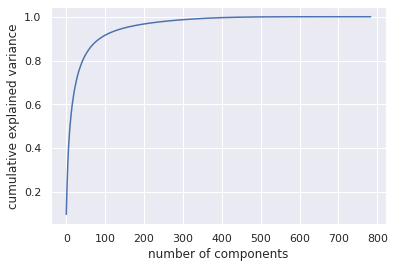

In [167]:
pca = PCA().fit(df_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

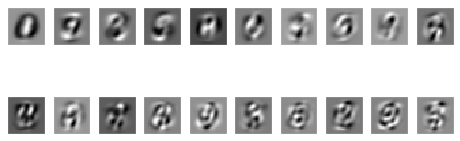

In [168]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
train_x_PCA = pca.fit_transform(df_x)
# plot PCA reduced components
fig, ax = plt.subplots(2, 10, figsize=(8, 3))
centers = pca.components_.reshape(20, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [169]:
kmeans_pca = MiniBatchKMeans(init=pca.components_ ,n_clusters=20)
kmeans_pca_clusters = kmeans_pca.fit_predict(df_x)
kmeans_pca.cluster_centers_.shape

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1745: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3.
  super()._check_params(X)


(20, 784)

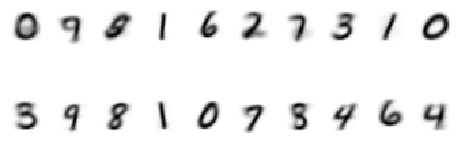

In [170]:
fig, ax = plt.subplots(factor_cluster, n_clusters, figsize=(8, 3))
centers = kmeans_pca.cluster_centers_.reshape(20, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [171]:
cluster_labels_pca = infer_cluster_labels(kmeans_pca.n_clusters, kmeans_pca.labels_, df_y.to_numpy())
X_clusters_pca = kmeans_pca.predict(df_x)
predicted_labels_pca = infer_data_labels(X_clusters_pca, cluster_labels_pca)
print(predicted_labels_pca[:20])
print(df_y.to_numpy()[:20])

[3 7 7 3 5 0 6 8 3 2 7 7 6 9 9 3 8 7 6 7]
[5 7 9 5 2 0 6 5 5 2 7 7 6 8 9 3 5 7 6 9]


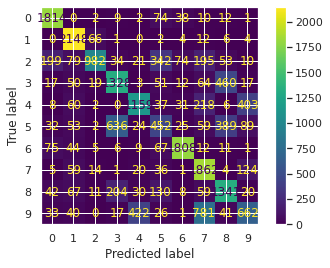

In [172]:
ConfusionMatrixDisplay.from_predictions(df_y, predicted_labels_pca)

In [173]:
print(classification_report(df_y, predicted_labels_pca))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1962
           1       0.83      0.96      0.89      2243
           2       0.89      0.49      0.64      1989
           3       0.59      0.66      0.62      2021
           4       0.69      0.60      0.64      1924
           5       0.37      0.26      0.30      1761
           6       0.90      0.89      0.90      2038
           7       0.57      0.88      0.69      2126
           8       0.58      0.70      0.63      1912
           9       0.50      0.33      0.39      2023

    accuracy                           0.68     19999
   macro avg       0.67      0.67      0.66     19999
weighted avg       0.68      0.68      0.66     19999

